Dependancies import

In [1]:
import os

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from scipy import stats
from sqlalchemy import create_engine

First I need to connect to the MySQL database created previously. I achieve this with the use of SQLAlchemy for a simple connection.

In [2]:
load_dotenv()
user = "root"
password = os.getenv("PASSWORD")
host = "127.0.0.1"
port = 3306
database = "droptime"


def get_connection():
    return create_engine(
        url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
            user, password, host, port, database
        )
    )

In [3]:
try:
    engine = get_connection()
    print(f"Connection to the {host} for user {user} created successfully.")
except Exception as ex:
    print("Connection could not be made due to the following error: \n", ex)

Connection to the 127.0.0.1 for user root created successfully.


After connecting to the database I convert the SQL tables to usable pandas DataFrames for Python.

In [4]:
orders = pd.read_sql_table("orders", engine)
products = pd.read_sql_table("products", engine)
orders_products = pd.read_sql_table("orders_products", engine)
route_segments = pd.read_sql_table("route_segments", engine)

I drop any duplicate rows from the data, and check for missing rows. In this case there are none, except for route_segments.order_id, but that's expected behavior, so I move on.

In [5]:
def checkDataQuality(tables: list):
    for table in tables:
        duplicates = table.duplicated()
        print(f"Removed {len(duplicates[duplicates])} duplicates.")
        table.drop_duplicates(inplace=True)
        for key in table.keys():
            missing_values = table[key].isna().sum()
            print(f"Number of missing values in {key}: {missing_values}")
        print("")

In [6]:
checkDataQuality([orders, products, orders_products, route_segments])

Removed 0 duplicates.
Number of missing values in order_id: 0
Number of missing values in customer_id: 0
Number of missing values in sector_id: 0
Number of missing values in planned_delivery_duration: 0

Removed 0 duplicates.
Number of missing values in product_id: 0
Number of missing values in weight: 0

Removed 0 duplicates.
Number of missing values in order_id: 0
Number of missing values in product_id: 0
Number of missing values in quantity: 0

Removed 0 duplicates.
Number of missing values in segment_id: 0
Number of missing values in driver_id: 0
Number of missing values in segment_type: 0
Number of missing values in order_id: 2734
Number of missing values in segment_start_time: 0
Number of missing values in segment_end_time: 0



Setting default chart options.

In [7]:
palette = ["#4D216D", "#2C86C1", "#6BAA75", "#FFC857"]
sns.set_palette(palette)
sns.set_style("ticks", {"grid.linestyle": ":", "axes.grid": True,'font.size': 22})

To create a delivery time histogram I use the route_segments table. I removed outliers and some of the samples that had segment end times that were earlier than the start times. I also removed the ones with delivery time equal to 0, as I'm assuming that the delivery needs to take some time, and there was a considerable gap between the 0 delivery time records and the next lowest ones.

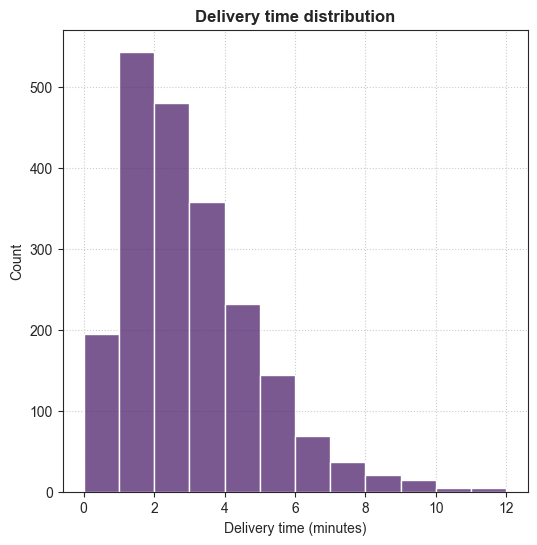

In [8]:
route_segments["delivery_duration"] = (
    route_segments["segment_end_time"] - route_segments["segment_start_time"]
).dt.total_seconds() / 60
mask1 = route_segments["order_id"].notna()
mask2 = (route_segments["delivery_duration"] > 0) & (
    route_segments["delivery_duration"] < 15
)
delivery_times = route_segments[mask1 & mask2]["delivery_duration"]

fig = plt.figure(figsize=[6, 6])
sns.histplot(x=delivery_times, bins=np.arange(delivery_times.max() + 1))
plt.title("Delivery time distribution", fontweight="bold")
plt.xlabel("Delivery time (minutes)");
plt.savefig('Task1_1',dpi=300)

To create the prediction error, I merged the orders and route segments tables on their mutual "order_id" key. I defined prediction error as the absolute difference between the planned delivery duration and the actual delivery duration (absolute value as it doesn't matter whether it was early or late, but what matters is the degree of error).

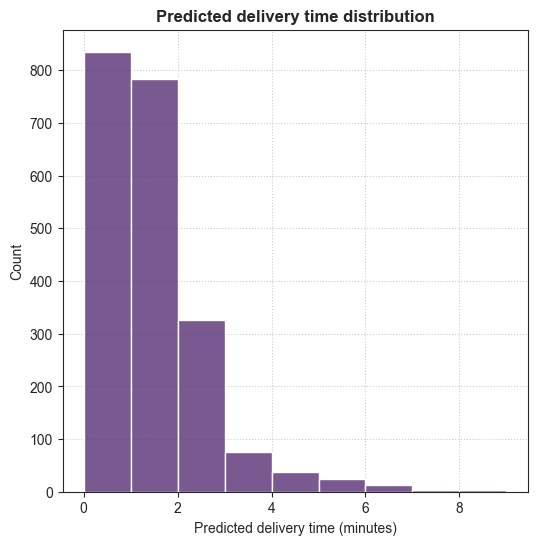

In [9]:
filtered_route_segments = route_segments[mask1 & mask2]
f_segments_orders = filtered_route_segments.merge(orders, on="order_id")
f_segments_orders["planned_delivery_duration"] /= 60
f_durations = f_segments_orders.loc[
    :, ("delivery_duration", "planned_delivery_duration")
]
f_durations["prediction_error"] = np.abs(
    f_durations["planned_delivery_duration"] - f_durations["delivery_duration"]
)

fig = plt.figure(figsize=[6, 6])
sns.histplot(
    data=f_durations,
    x="prediction_error",
    bins=np.arange(f_durations["prediction_error"].max() + 1),
)
plt.title("Predicted delivery time distribution", fontweight="bold")
plt.xlabel("Predicted delivery time (minutes)");
plt.savefig('Task1_2',dpi=300)


To create this graph I grouped the previously joined tables by sector_id and then delivery time medians. I decided to compare the delivery times by sector to the planned delivery times, however the planned delivery times are equal because of the way that the value is calculated. To solve this, I submit my proposal in the "research.pdf".

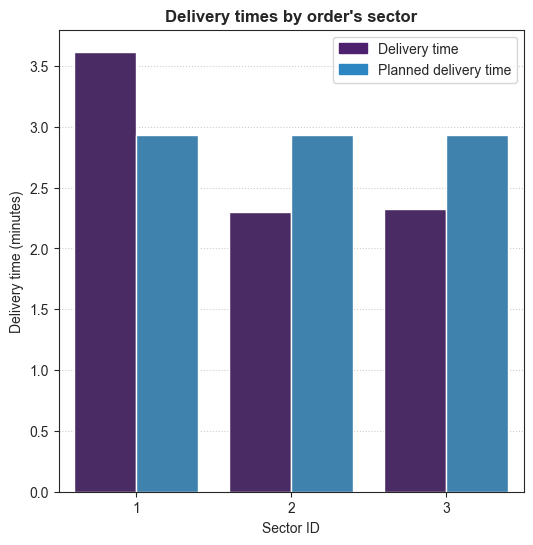

In [10]:
median_sector_durations = (
    f_segments_orders.loc[
        :, ("sector_id", "delivery_duration", "planned_delivery_duration")
    ]
    .groupby(["sector_id"], as_index=False)
    .median()
)
temp_median_sd = median_sector_durations.melt("sector_id", var_name="a", value_name="b")

fig = plt.figure(figsize=[6, 6])
sns.barplot(data=temp_median_sd, x="sector_id", y="b", hue="a", legend=False)

del_time_legend = mpatches.Patch(color="#4D216D", label="Delivery time")
pdel_time_legend = mpatches.Patch(color="#2C86C1", label="Planned delivery time")

plt.legend(handles=[del_time_legend, pdel_time_legend])
plt.title("Delivery times by order's sector", fontweight="bold")
plt.xlabel("Sector ID")
plt.ylabel("Delivery time (minutes)");
plt.savefig('Task1_3',dpi=300)


To explore the data and try to find some trends in regards to delivery time I tried multiple approaches.

Chart 1 & 2:
I explored the relationship between the order's delivery time and its' driver. First, I calculated average delivery times for each of the drivers. From the charts you can clearly see that delivery time is heavily dependant on the driver. On Chart 2, to quantify how far away each driver is from the expected values, I calculated the offset of their delivery time means to the expected time. Again, as the expected time is the same for each driver the results are basically a different way of portraying Chart 1, however if the expected times were, for example, unique to each sector, Chart 2 would've been more useful.

Chart 3:
I explored the relationship between the total weight of the orders and its' delivery time. To get the total weight I merged the tables on their common IDs, multiplied the quantity of the ordered product by weight of a single unit and then summed for each order. Based on Chart 3 and the correlation coefficient between the variables I found that there is a weak-moderate relationship between them i.e. the heavier the package, chances are the longer it will take to deliver.

Chart 4:
I explored the relationship between delivery time and the day of the week the order was made. To get the weekday I extracted the date from the route segments table. Then I grouped by the weekday, calculated the mean of the delivery times and visualized it.  From Chart 4 you can read that the delivery times get longer at the start and end of the week, but get faster (up to almost 8 % from the mean on Thursday) in the middle of the week.

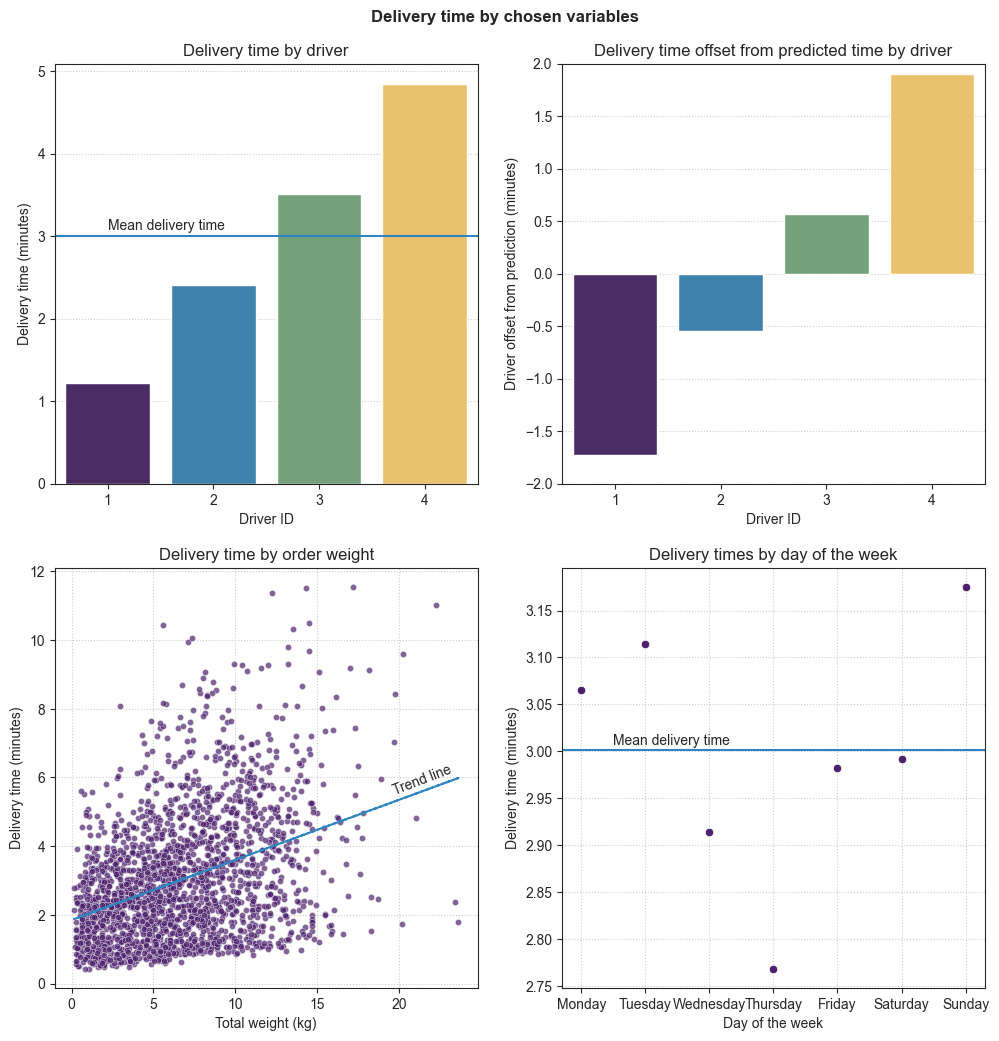

In [17]:
driver_times_means = (
    f_segments_orders.loc[
        :, ("driver_id", "delivery_duration", "planned_delivery_duration")
    ]
    .groupby("driver_id", as_index=False)
    .mean()
)
driver_times_means["driver_offset_from_prediction"] = (
    driver_times_means["delivery_duration"]
    - driver_times_means["planned_delivery_duration"]
)

fig, axes = plt.subplots(2, 2, figsize=[12,12])

orders_total_weight = products.merge(orders_products, on="product_id").loc[
    :, ("order_id", "weight", "quantity")
]
orders_total_weight["total_weight"] = (
    orders_total_weight["weight"] * orders_total_weight["quantity"] / 1000
)
orders_total_weight = (
    orders_total_weight.loc[:, ("order_id", "total_weight")]
    .groupby(["order_id"], as_index=False)
    .sum()
)
orders_times_weights = orders_total_weight.merge(f_segments_orders, on="order_id").loc[
    :, ("delivery_duration", "total_weight")
]

f_segments_orders["weekday"] = f_segments_orders["segment_end_time"].dt.weekday
orders_by_date = (
    f_segments_orders.loc[:, ("delivery_duration", "weekday")]
    .groupby(["weekday"], as_index=False)
    .mean()
)
mean_delivery_duration = orders_by_date["delivery_duration"].mean()

fig.suptitle("Delivery time by chosen variables", y=0.925, fontweight="bold")

sns.barplot(
    data=driver_times_means,
    x="driver_id",
    y="delivery_duration",
    hue="driver_id",
    palette=palette,
    legend=False,
    ax=axes[0][0],
)
axes[0][0].axhline(y=mean_delivery_duration, color="#2C86C1")
axes[0][0].text(
    0, mean_delivery_duration + 0.08, "Mean delivery time", fontweight="light"
)
axes[0][0].set_title("Delivery time by driver")
axes[0][0].set_xlabel("Driver ID")
axes[0][0].set_ylabel("Delivery time (minutes)")


sns.barplot(
    data=driver_times_means,
    x="driver_id",
    y="driver_offset_from_prediction",
    hue="driver_id",
    palette=palette,
    legend=False,
    ax=axes[0][1],
)
axes[0][1].set_ylim([-2,2])
axes[0][1].set_title("Delivery time offset from predicted time by driver")
axes[0][1].set_xlabel("Driver ID")
axes[0][1].set_ylabel("Driver offset from prediction (minutes)")

sns.scatterplot(
    data=orders_times_weights,
    x="total_weight",
    y="delivery_duration",
    s=20,
    alpha=0.7,
    ax=axes[1][0],
)
z = np.polyfit(
    orders_times_weights["total_weight"], orders_times_weights["delivery_duration"], 1
)
p = np.poly1d(z)
axes[1][0].plot(
    orders_times_weights["total_weight"],
    p(orders_times_weights["total_weight"]),
    "--",
    color="#2C86C1",
)
axes[1][0].text(19.5, 5.5, "Trend line", rotation=21)
axes[1][0].set_title("Delivery time by order weight")
axes[1][0].set_xlabel("Total weight (kg)")
axes[1][0].set_ylabel("Delivery time (minutes)")

weight_time_coef = np.corrcoef(
    orders_times_weights["total_weight"], orders_times_weights["delivery_duration"]
)

weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
sns.scatterplot(data=orders_by_date, x="weekday", y="delivery_duration", ax=axes[1][1])
plt.axhline(y=mean_delivery_duration, color="#2C86C1")
plt.text(0.5, mean_delivery_duration + 0.005, "Mean delivery time", fontweight="light")
axes[1][1].xaxis.set_ticks(np.arange(7))
axes[1][1].set_xticklabels(weekdays)
axes[1][1].set_title("Delivery times by day of the week")
axes[1][1].set_xlabel("Day of the week")
axes[1][1].set_ylabel("Delivery time (minutes)")
plt.savefig('Task1_4')

thurs_mean = orders_by_date[orders_by_date["weekday"] == 3]["delivery_duration"]
percentage_drop_thurs = 100 - thurs_mean * 100 / mean_delivery_duration
sun_mean = orders_by_date[orders_by_date["weekday"] == 6]["delivery_duration"]
percentage_high_sun = sun_mean * 100 / mean_delivery_duration - 100